In [1]:
import opendatasets as od
import pandas as pd
import numpy as np
import random
import re
import string
import cleantext
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

## Download dataset

In [2]:
od.download("https://www.kaggle.com/datasets/andrewmvd/cyberbullying-classification")

Skipping, found downloaded files in ".\cyberbullying-classification" (use force=True to force download)


## Load dataset

In [3]:
df_bullying = pd.read_csv("cyberbullying-classification/cyberbullying_tweets.csv")

In [4]:
df_bullying.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


## Dataset exploration

In [5]:
df_bullying.isnull().sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

In [6]:
df_bullying.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [7]:
df_bullying['cyberbullying_type'].unique()

array(['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying',
       'age', 'ethnicity'], dtype=object)

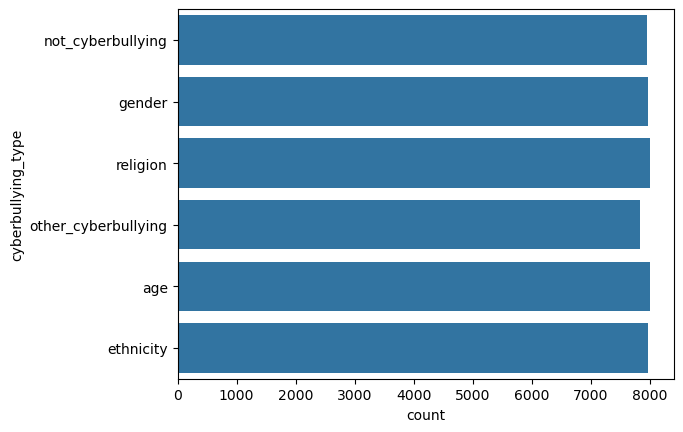

In [8]:
sns.countplot(df_bullying['cyberbullying_type'])
plt.show()

In [9]:
##plotting random text samples 
random_index = random.randint(0,len(df_bullying)-10)
for _,text,label in df_bullying[['tweet_text','cyberbullying_type']][random_index:random_index+10].itertuples():
    print(f'Text:{text}\nLabel:{label}')

Text:ISLAM MY Father Allah Almighty Never was, is, nor neither will be a Terrorist, Extremist, ISIS, Suicide Bombers of all the Stupid names you called the ALmighty, these phrases simply are NOT in the HOLY Quran Sharif. Get the TRUTH straight who did this to Hate ISLAM? ANSWER ME?!!
Label:religion
Text:What about the demographic change of kashmiri pandits by Islamic terrorism. Kashmir belongs to also pandits and they want to be with India. If you want azad kashmir then u can shift to POK azad kashmir.
Label:religion
Text:WELL, MATT...ISIS IS IN THE HEARTS AND BRAINS OF EVERY MUSLIM. IF A YOUNG MUSLIM MAN IS TAKING HIS QURAN'S TEACHING SERIOUSLY AS TO "KILL ALL INFIDELS" IT DOESN'T TAKE MUCH TO GET THE ISIS LONE TERRORIST COMING OUTOF HIM. HERE OR IN THE MIDDLE EAST ANYWHERE. IT AIN'T WIPED OUT
Label:religion
Text:I am Chinese, I have some Muslim friends from Xinjiang, I have also been to Xi’an where the main population is Muslims, I want to say that everything you say is false, Stop d

## Text preprocessing

In [10]:
def remove_urls(text):
    text = text.split()
    text = ' '.join([word for word in text if word[:4]!='http'])
    return text
    
def remove_user_names(text):
    text = text.split()
    text = ' '.join([word for word in text if word[0]!='@'])
    return text
    
def remove_emojis(text):
    text = text.split()
    text = ' '.join([cleantext.clean(word,no_emoji=True) for word in text])
    return text

def remove_hastags(text):
    text = text.split()
    text = ' '.join([word for word in text if word[0]!='#'])
    return text

In [11]:
## Cleaning the text from unnecessary punctuation , stopwords etc
## Lemmatize words

lemmatizer = WordNetLemmatizer()
def clean_and_lemmatize(text):
    text = re.sub('^a-zA-Z',' ', text)
    text = re.sub('[\d-]', ' ', text)
    text = text.lower()
    text = text.split()
    [word for word in text if word not in string.punctuation]
    [lemmatizer.lemmatize(word) for word in text if word not in stopwords.words('english')]
    text = ' '.join(text)
    if len(text)>0:
        return text
    else:
        pass

In [12]:
df_bullying['text_clean']=df_bullying['tweet_text'].apply(remove_urls)
df_bullying['text_clean']=df_bullying['text_clean'].apply(remove_user_names)
df_bullying['text_clean']=df_bullying['text_clean'].apply(remove_emojis)
df_bullying['text_clean']=df_bullying['text_clean'].apply(remove_hastags)

In [13]:
df_bullying['text_clean']=df_bullying['text_clean'].apply(clean_and_lemmatize)

In [14]:
df_bullying[['text_clean']].isnull().sum()

text_clean    367
dtype: int64

In [15]:
df_bullying.dropna(inplace=True)
df_bullying.reset_index(drop=True)

,tweet_text,cyberbullying_type,text_clean
0,"In other words #katandandre, your food was cra...",not_cyberbullying,in other words your food was crapilicious!
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,why is so white?
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,a classy whore? or more red velvet cupcakes?
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,"meh. :p thanks for the heads up, but not too c..."
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,this is an isis account pretending to be a kur...
...,...,...,...
47320,"Black ppl aren't expected to do anything, depe...",ethnicity,"black ppl aren't expected to do anything, depe..."
47321,Turner did not withhold his disappointment. Tu...,ethnicity,turner did not withhold his disappointment. tu...
47322,I swear to God. This dumb nigger bitch. I have...,ethnicity,i swear to god. this dumb nigger bitch. i have...
47323,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity,yea fuck you rt if youre a nigger fucking unfo...


## Splitting data into dependent and independent features

In [16]:
X = df_bullying.iloc[:,-1]
y = df_bullying['cyberbullying_type']

# Splitting data into train and test

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=True)

In [18]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((37860,), (9465,), (37860,), (9465,))

# Encoding labels

In [19]:
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

## Creation of an helper function for model results

In [20]:
def model_results(y_test, y_pred):
    precision, recall,f1,_ = precision_recall_fscore_support(y_test, y_pred)
    return {'Precision':np.mean(precision),'Recall':np.mean(recall),'F1-Score':np.mean(f1)}

## Bag of words

In [21]:
vectorizer = CountVectorizer()

In [22]:
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

In [23]:
classifier=RandomForestClassifier().fit(X_train_bow, y_train)

In [24]:
classifier.score(X_test_bow, y_test)

0.7933438985736926

In [25]:
bow_preds = classifier.predict(X_test_bow)

## TF-IDF

In [26]:
tfidf = TfidfVectorizer()

In [27]:
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [28]:
classifier2=RandomForestClassifier().fit(X_train_tfidf, y_train)

In [29]:
classifier2.score(X_test_tfidf, y_test)

0.7888008452192288

In [30]:
tfidf_preds = classifier2.predict(X_test_tfidf)

# Universal Sentence Encoder model

In [31]:
import tensorflow_hub as hub
embed_layer = hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/large/2",
                             input_shape=[],name='use')

## Creation of train and test datasets

In [32]:
X_train_tf = tf.data.Dataset.from_tensor_slices(X_train)
y_train_tf = tf.data.Dataset.from_tensor_slices(y_train_encoded)
X_test_tf = tf.data.Dataset.from_tensor_slices(X_test)
y_test_tf = tf.data.Dataset.from_tensor_slices(y_test_encoded)

In [33]:
train_dataset = tf.data.Dataset.zip((X_train_tf, y_train_tf)).batch(32).prefetch(tf.data.AUTOTUNE) 
test_dataset = tf.data.Dataset.zip((X_test_tf, y_test_tf)).batch(32).prefetch(tf.data.AUTOTUNE) 

## Creation of some callbacks

In [34]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-8, patience=2)
early_stop = tf.keras.callbacks.EarlyStopping(patience=3)

### Building model with Functional API

In [35]:
num_classes=len(df_bullying.cyberbullying_type.unique())
num_classes

6

In [36]:
inputs = layers.Input(shape=[], dtype=tf.string, name='input_layer')
x = embed_layer(inputs)
outputs = layers.Dense(num_classes, activation='softmax', name='output_layer')(x)
model_0 = tf.keras.Model(inputs, outputs, name='sentence_encoder_model')

In [37]:
#Visualize model summary
model_0.summary()

Model: "sentence_encoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None,)]                 0         
                                                                 
 use (KerasLayer)            (None, 512)               147354880 
                                                                 
 output_layer (Dense)        (None, 6)                 3078      
                                                                 
Total params: 147,357,958
Trainable params: 3,078
Non-trainable params: 147,354,880
_________________________________________________________________


In [38]:
#compile the model
model_0.compile(loss='sparse_categorical_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

In [39]:
#Fit the model
model_0_history = model_0.fit(train_dataset,
                              steps_per_epoch=len(train_dataset),
                              validation_data=test_dataset,
                              validation_steps=int(0.15*len(test_dataset)),#validates only on 15% of test data
                              epochs=5, callbacks=[early_stop,reduce_lr])

Epoch 1/5
1184/1184 [==============================] - 312s 249ms/step - loss: 1.0410 - accuracy: 0.7274 - val_loss: 0.7368 - val_accuracy: 0.7628 - lr: 0.0010
Epoch 2/5
1184/1184 [==============================] - 288s 244ms/step - loss: 0.6401 - accuracy: 0.7932 - val_loss: 0.5993 - val_accuracy: 0.7855 - lr: 0.0010
Epoch 3/5
1184/1184 [==============================] - 287s 243ms/step - loss: 0.5510 - accuracy: 0.8056 - val_loss: 0.5481 - val_accuracy: 0.7983 - lr: 0.0010
Epoch 4/5
1184/1184 [==============================] - 286s 242ms/step - loss: 0.5108 - accuracy: 0.8143 - val_loss: 0.5221 - val_accuracy: 0.8011 - lr: 0.0010
Epoch 5/5
1184/1184 [==============================] - 285s 241ms/step - loss: 0.4880 - accuracy: 0.8186 - val_loss: 0.5069 - val_accuracy: 0.8054 - lr: 0.0010


In [40]:
model_0.evaluate(test_dataset)

296/296 [==============================] - 71s 240ms/step - loss: 0.4906 - accuracy: 0.8116


[0.4905882179737091, 0.8116217851638794]

In [41]:
y_pred_probs = model_0.predict(test_dataset)
y_preds_use = tf.argmax(y_pred_probs, axis=1) 

296/296 [==============================] - 76s 241ms/step


## Plotting all results

In [42]:
bow_results = model_results(y_test,bow_preds)
tfidf_results = model_results(y_test,tfidf_preds)
use_results = model_results(y_test_encoded, y_preds_use)

In [43]:
all_results = pd.DataFrame({'RandForest BOW':bow_results,'RandForest TF-IDF':tfidf_results,'UniversalSentenceEncoder':use_results}).transpose()

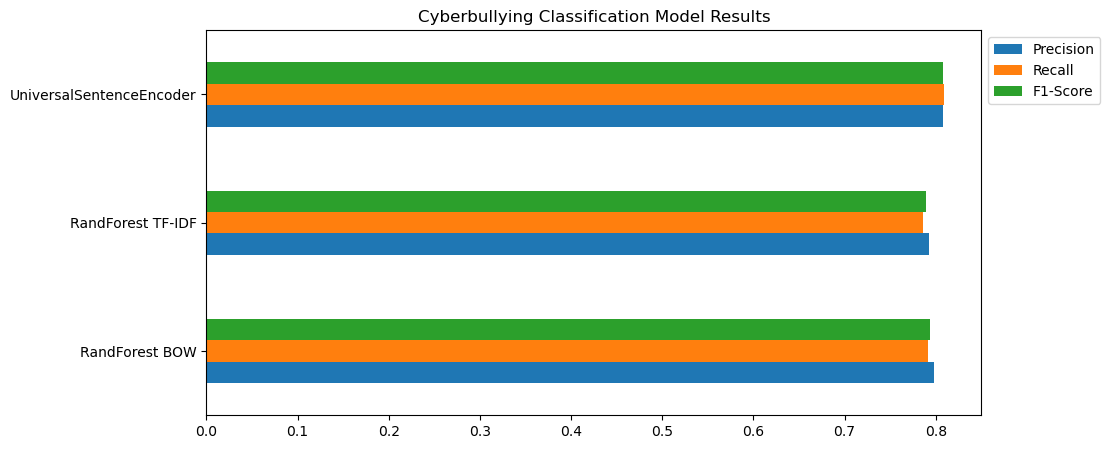

In [44]:
all_results.plot(kind='barh', title='Cyberbullying Classification Model Results', figsize=(10,5)).legend(bbox_to_anchor=(1.,1.));

## BOW

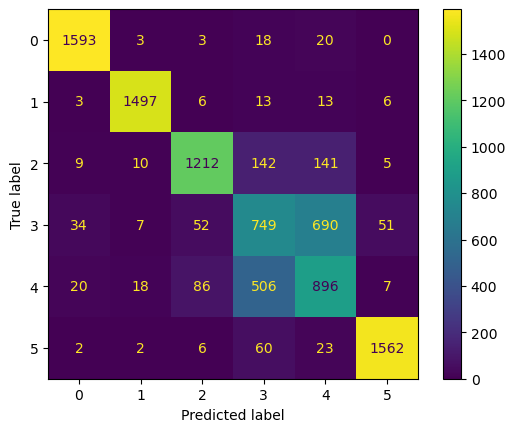

                     precision    recall  f1-score   support

                age       0.96      0.97      0.97      1637
          ethnicity       0.97      0.97      0.97      1538
             gender       0.89      0.80      0.84      1519
  not_cyberbullying       0.50      0.47      0.49      1583
other_cyberbullying       0.50      0.58      0.54      1533
           religion       0.96      0.94      0.95      1655

           accuracy                           0.79      9465
          macro avg       0.80      0.79      0.79      9465
       weighted avg       0.80      0.79      0.80      9465



In [45]:
cm=confusion_matrix(y_test, bow_preds)
disp=ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()
print(classification_report(y_test, bow_preds))

## TF-IDF

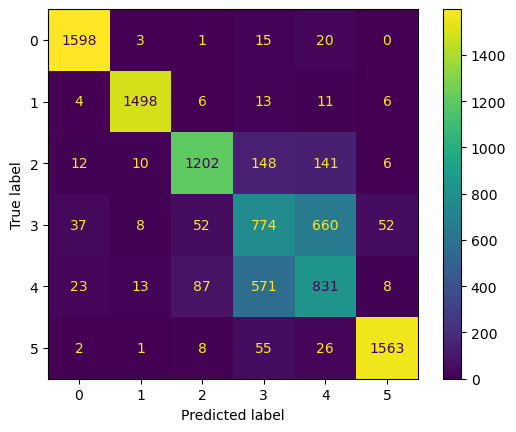

                     precision    recall  f1-score   support

                age       0.95      0.98      0.96      1637
          ethnicity       0.98      0.97      0.98      1538
             gender       0.89      0.79      0.84      1519
  not_cyberbullying       0.49      0.49      0.49      1583
other_cyberbullying       0.49      0.54      0.52      1533
           religion       0.96      0.94      0.95      1655

           accuracy                           0.79      9465
          macro avg       0.79      0.79      0.79      9465
       weighted avg       0.79      0.79      0.79      9465



In [46]:
cm=confusion_matrix(y_test, tfidf_preds)
disp=ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()
print(classification_report(y_test, tfidf_preds))

## Universal Sentence Encoder

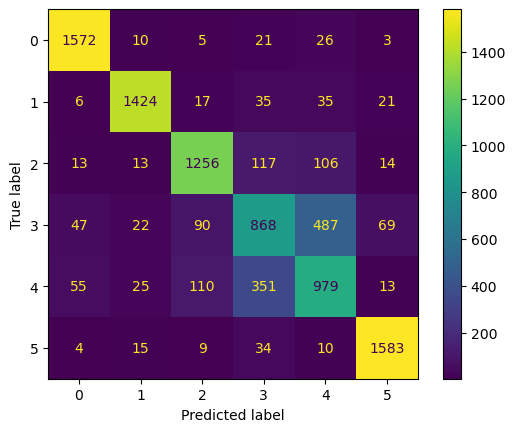

                     precision    recall  f1-score   support

  not_cyberbullying       0.93      0.96      0.94      1637
             gender       0.94      0.93      0.93      1538
           religion       0.84      0.83      0.84      1519
other_cyberbullying       0.61      0.55      0.58      1583
                age       0.60      0.64      0.62      1533
          ethnicity       0.93      0.96      0.94      1655

           accuracy                           0.81      9465
          macro avg       0.81      0.81      0.81      9465
       weighted avg       0.81      0.81      0.81      9465



In [47]:
cm=confusion_matrix(y_test_encoded, y_preds_use)
disp=ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()
print(classification_report(y_test_encoded, y_preds_use,target_names=df_bullying.cyberbullying_type.unique()))